## Import

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

import math
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 27 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (46.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

## csv to parquet

In [ ]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [ ]:
csv_to_parquet('/content/drive/MyDrive/dacon/data/train.csv', 'train')
csv_to_parquet('/content/drive/MyDrive/dacon/data/test.csv', 'test')

train Done.
test Done.


## 데이터 불러오기

In [ ]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')

In [ ]:
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,목,16,1,107,-,0,0,50.0,...,0,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0
4701213,TRAIN_4701213,20220331,목,2,2,107,-,0,0,80.0,...,3,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0
4701214,TRAIN_4701214,20220613,월,22,2,103,일반국도12호선,0,0,60.0,...,0,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0
4701215,TRAIN_4701215,20211020,수,2,2,103,일반국도95호선,0,0,80.0,...,0,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0


In [ ]:
test

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
0,TEST_000000,20220825,목,17,3,107,연삼로,0,0,70.0,...,0.0,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음
1,TEST_000001,20220809,화,12,2,103,일반국도12호선,0,0,70.0,...,0.0,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음
2,TEST_000002,20220805,금,2,1,103,일반국도16호선,0,0,60.0,...,0.0,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음
3,TEST_000003,20220818,목,23,3,103,일반국도11호선,0,0,70.0,...,0.0,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음
4,TEST_000004,20220810,수,17,3,106,번영로,0,0,70.0,...,0.0,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291236,TEST_291236,20220827,토,5,1,103,일반국도16호선,0,0,80.0,...,0.0,0,월산마을,33.472819,126.463030,없음,도근교,33.470483,126.460846,없음
291237,TEST_291237,20220819,금,20,2,103,일반국도11호선,0,0,60.0,...,0.0,0,영주교,33.305359,126.598914,없음,하례입구삼거리,33.300796,126.600332,없음
291238,TEST_291238,20220805,금,11,1,107,신대로,0,0,30.0,...,0.0,0,마리나사거리,33.493624,126.496769,있음,칠오광장사거리,33.497500,126.496946,있음
291239,TEST_291239,20220812,금,7,2,107,경찰로,0,0,60.0,...,0.0,0,국민의료보험관리공단,33.254782,126.507014,없음,의료보험조합,33.255659,126.507333,없음


In [ ]:
train['month']=train['base_date']
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,month
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,20220623
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,20220728
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,20211010
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,20220311
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,20211005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,목,16,1,107,-,0,0,50.0,...,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0,20211104
4701213,TRAIN_4701213,20220331,목,2,2,107,-,0,0,80.0,...,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0,20220331
4701214,TRAIN_4701214,20220613,월,22,2,103,일반국도12호선,0,0,60.0,...,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0,20220613
4701215,TRAIN_4701215,20211020,수,2,2,103,일반국도95호선,0,0,80.0,...,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0,20211020


In [ ]:
train_go=train.copy()
train_go

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,month
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,20220623
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,20220728
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,20211010
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,20220311
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,20211005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,목,16,1,107,-,0,0,50.0,...,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0,20211104
4701213,TRAIN_4701213,20220331,목,2,2,107,-,0,0,80.0,...,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0,20220331
4701214,TRAIN_4701214,20220613,월,22,2,103,일반국도12호선,0,0,60.0,...,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0,20220613
4701215,TRAIN_4701215,20211020,수,2,2,103,일반국도95호선,0,0,80.0,...,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0,20211020


In [ ]:
train_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [ ]:
train_go['month']

0          20220623
1          20220728
2          20211010
3          20220311
4          20211005
             ...   
4701212    20211104
4701213    20220331
4701214    20220613
4701215    20211020
4701216    20211019
Name: month, Length: 4701217, dtype: int64

In [ ]:
train_go['month'] = train_go['month'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

In [ ]:
train_go['month'] = train_go['month'].dt.month

In [ ]:
train_go

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,month
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,6
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,7
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,10
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,3
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,목,16,1,107,-,0,0,50.0,...,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0,11
4701213,TRAIN_4701213,20220331,목,2,2,107,-,0,0,80.0,...,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0,3
4701214,TRAIN_4701214,20220613,월,22,2,103,일반국도12호선,0,0,60.0,...,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0,6
4701215,TRAIN_4701215,20211020,수,2,2,103,일반국도95호선,0,0,80.0,...,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0,10


In [ ]:
workday = ['월', '화', '수', '목', '금']
playday = ['토', '일']

weekend=[]

for row in train_go['day_of_week']:
    if row in workday:
        weekend.append('0')
    elif row in train_go['day_of_week']:
        weekend.append('1')

train_go['weekend'] = weekend

ValueError: ignored

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [ ]:
#start_node, end_node 상관계수 알아보기(eda)


## EDA

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_

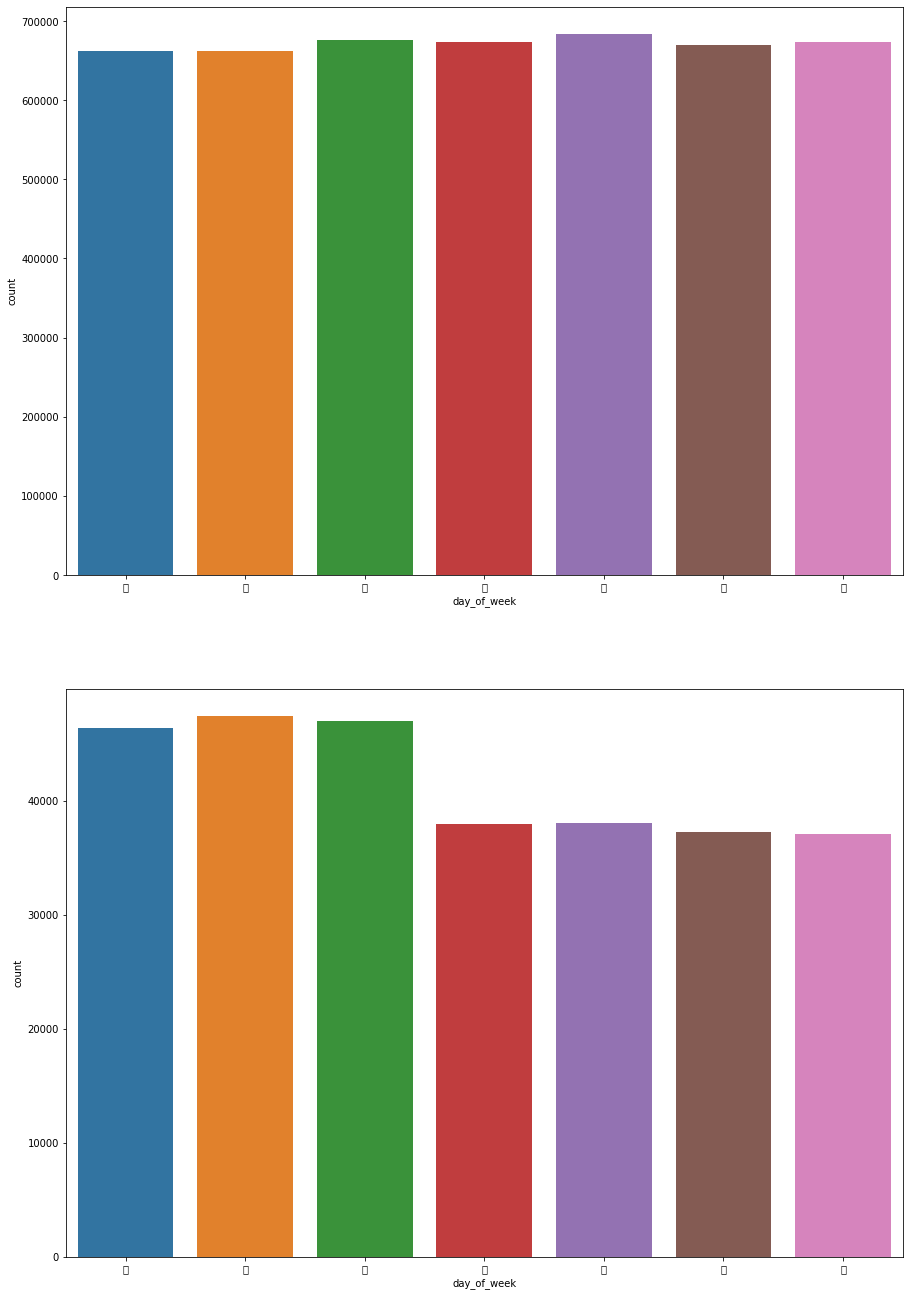

In [ ]:
# 요일
date_order = ['월','화','수','목','금','토','일']

fig, axes = plt.subplots(2, 1, figsize=(15,23))

sns.countplot(data=train, x='day_of_week',ax=axes[0], order=date_order)
sns.countplot(data=test, x='day_of_week',ax=axes[1], order=date_order)

In [ ]:
train['road_name'].unique() # '-' 전처리 필요

array(['지방도1112호선', '일반국도11호선', '일반국도16호선', '태평로', '일반국도12호선', '경찰로', '-',
       '외도천교', '일반국도99호선', '중정로', '번영로', '연동로', '중산간서로', '지방도1118호선',
       '새서귀로', '지방도1115호선', '지방도1132호선', '어시천교', '지방도1120호선', '삼무로',
       '애조로', '지방도1116호선', '일반국도95호선', '동부관광도로', '동홍로', '지방도97호선', '중문로',
       '연삼로', '중앙로', '산서로', '지방도1117호선', '연북로', '남조로', '지방도1119호선', '동문로',
       '한천로', '삼봉로', '고평교', '연북2교', '관광단지로', '권학로', '시청로', '신대로', '서사로',
       '관덕로', '관광단지1로', '신산로', '관광단지2로', '신광로', '지방도1136호선', '첨단로',
       '제2거로교', '시민광장로', '임항로', '수영장길', '애원로', '삼성로', '일주동로', '호서중앙로',
       '아봉로', '호근로'], dtype=object)

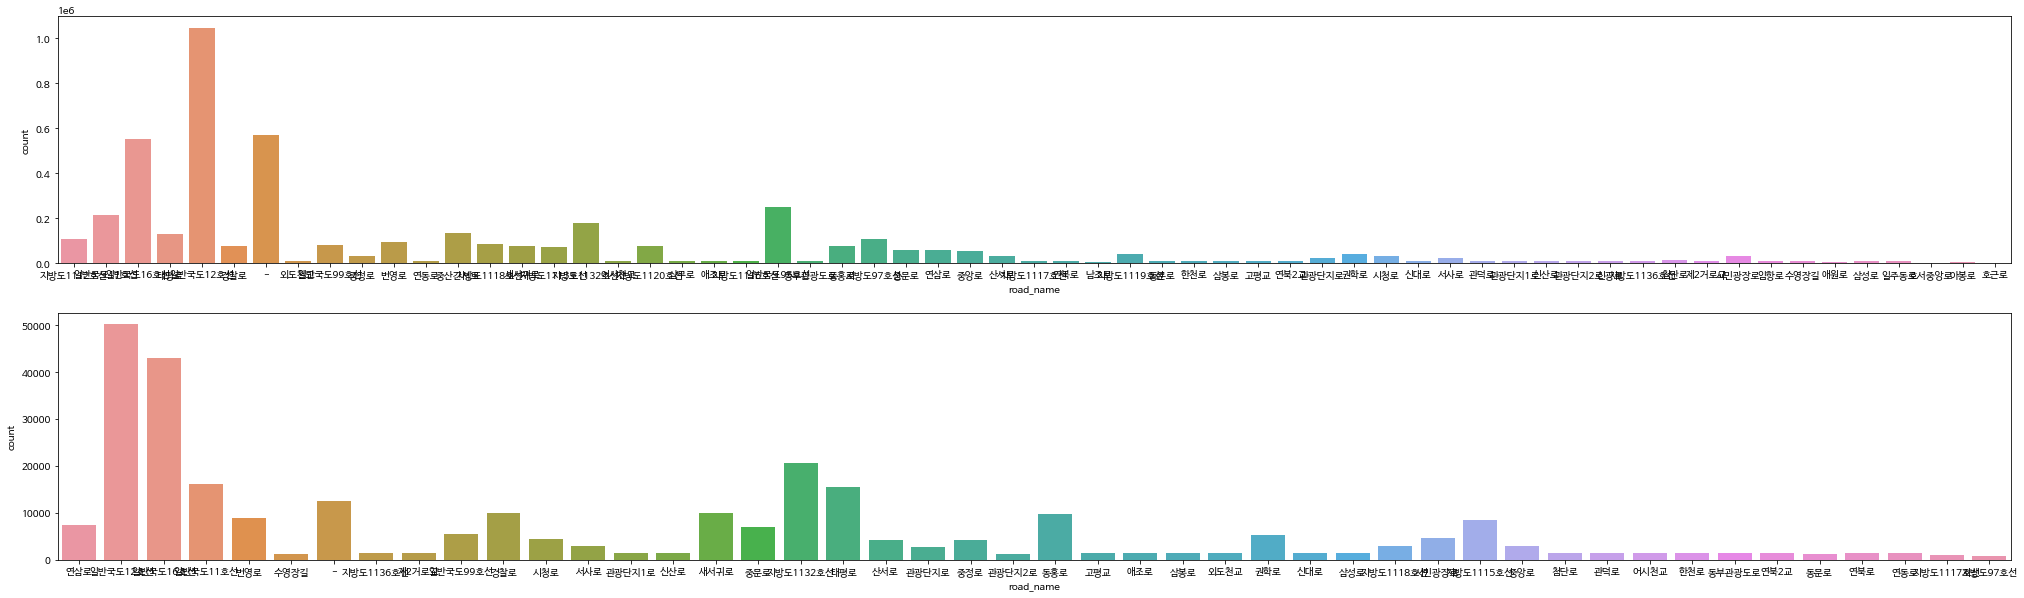

In [ ]:
#road_name(도로명)
fig, axes = plt.subplots(2, 1, figsize=(35,10))

sns.countplot(data=train, x='road_name',ax=axes[0])
sns.countplot(data=test, x='road_name',ax=axes[1])

In [ ]:
print(train['road_rating'].unique())
print(test['road_rating'].unique())

[106 103 107]
[107 103 106]


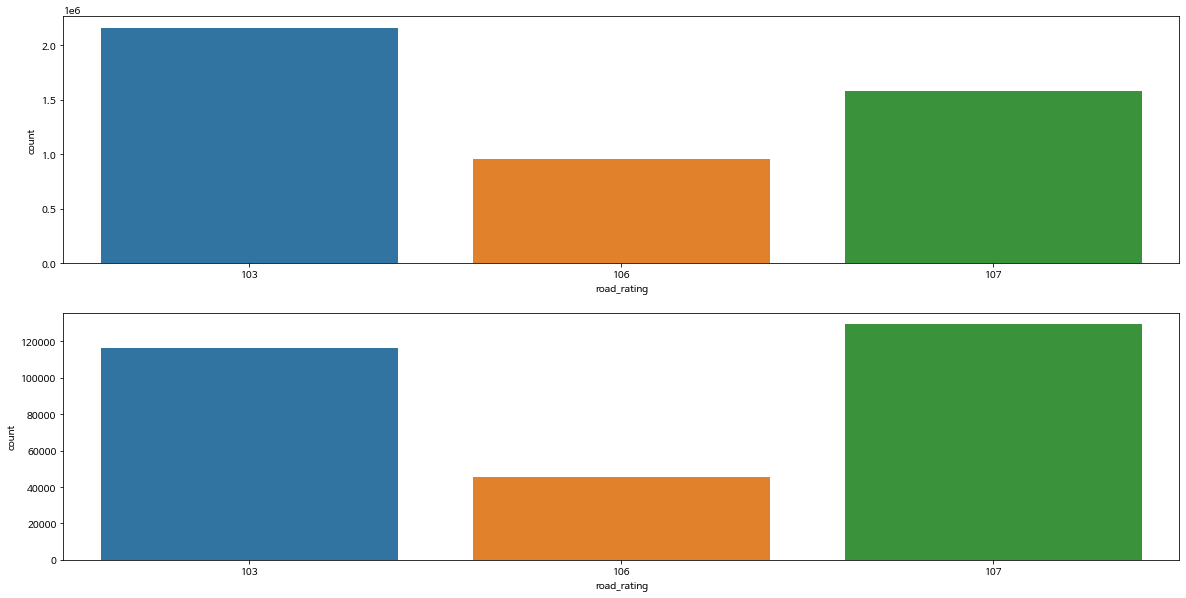

In [ ]:
#road_rating(도로등급)
fig, axes = plt.subplots(2, 1, figsize=(20,10))

sns.countplot(data=train, x='road_rating',ax=axes[0])
sns.countplot(data=test, x='road_rating',ax=axes[1])

In [ ]:
print(train['base_hour'].unique())
print(test['base_hour'].unique())

[17 21  7 13  8  0 16 15  2 11 10 22 12 23 14  6  9 19  1  4 20 18  3  5]
[17 12  2 23  1  4  5  3 10 21 15  6 20  8 22 14  9 19 13  0 16 11 18  7]


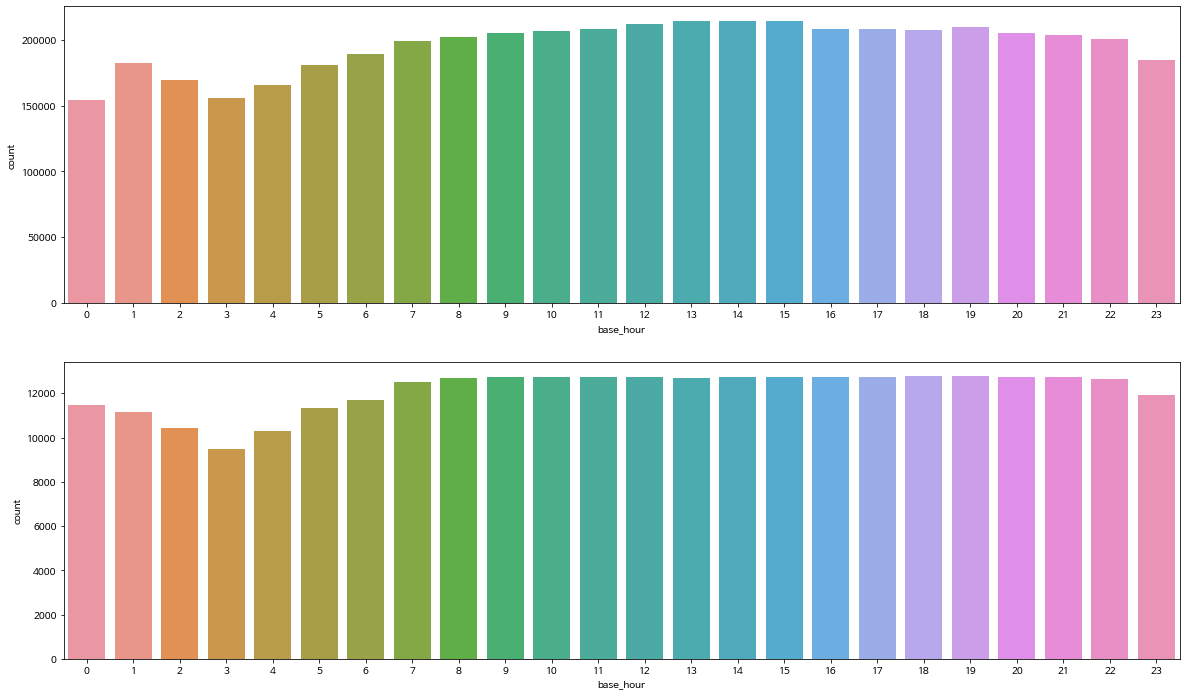

In [ ]:
#road_rating(도로등급)
fig, axes = plt.subplots(2, 1, figsize=(20,12))

sns.countplot(data=train, x='base_hour',ax=axes[0])
sns.countplot(data=test, x='base_hour',ax=axes[1])

In [ ]:
#lane_count(차로수)
print(train['lane_count'].unique())
print(test['lane_count'].unique())

[1 2 3]
[3 2 1]


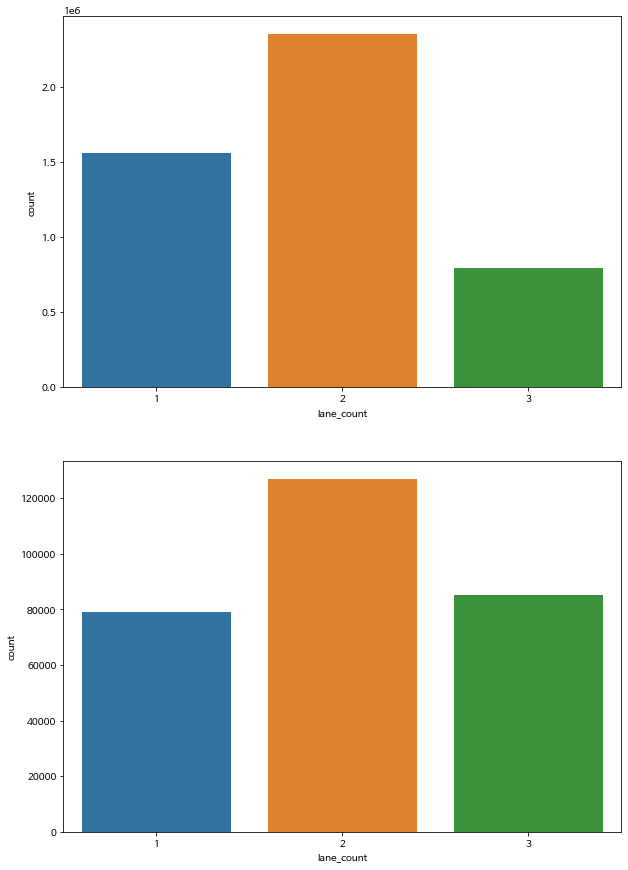

In [ ]:
#lane_count(차로수)
fig, axes = plt.subplots(2, 1, figsize=(10,15))

sns.countplot(data=train, x='lane_count',ax=axes[0])
sns.countplot(data=test, x='lane_count',ax=axes[1])

In [ ]:
print(train['connect_code'].unique())
print(test['connect_code'].unique())

[  0 103]
[0]


In [ ]:
str_col = ['day_of_week','start_turn_restricted','end_turn_restricted']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

    print(i, le.classes_)

day_of_week ['금' '목' '수' '월' '일' '토' '화']
start_turn_restricted ['없음' '있음']
end_turn_restricted ['없음' '있음']


In [ ]:
y_train = train['target'] 

# [아이디, 날짜, 평균속도, 도로명, 시작지점명, 도착지점명, 통과제한차량]
X_train = train.drop(['id','base_date', 'target','road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

test = test.drop(['id','base_date', 'road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

print(X_train.shape)
print(y_train.shape)
print(test.shape)

(4701217, 16)
(4701217,)
(291241, 16)


In [ ]:
X_train = train.drop(['id','base_date', 'target','road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

In [ ]:
# 요일, 시간대, 차로수, 도로등급, 중용구간 여부, 연결로 코드, 최고속도제한, 통과제한하중, 통과제한높이
# 도로유형, 시작지점위도, 시작지점경도, 시작지점의 회전제한 유무
# 도착지점위도, 도착지점경도, 도착지점의 회전제한 유무
# 16개
X_train.head(7)

,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted
0,1,17,1,106,0,0,60.0,32400.0,0.0,3,33.427747,126.662612,0,33.427749,126.662335,0
1,1,21,2,103,0,0,60.0,0.0,0.0,0,33.500730,126.529107,1,33.504811,126.526240,0
2,4,7,2,103,0,0,80.0,0.0,0.0,0,33.279145,126.368598,0,33.280072,126.362147,0
3,0,13,2,107,0,0,50.0,0.0,0.0,0,33.246081,126.567204,0,33.245565,126.566228,0
4,6,8,2,103,0,0,80.0,0.0,0.0,0,33.462214,126.326551,0,33.462677,126.330152,0
5,3,7,2,107,0,0,60.0,0.0,0.0,0,33.249949,126.505664,0,33.252183,126.506069,0
6,1,0,2,107,0,0,60.0,0.0,0.0,0,33.418412,126.268029,0,33.414175,126.269378,0


In [ ]:
# 7월 데이터를 빼서 테스트데이터로 사용하면 좋을듯
train.sort_values('base_date')

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
430379,TRAIN_0430379,20210901,2,16,3,106,지방도1132호선,0,0,70.0,...,3,진동1로,33.518987,126.568861,1,동중입구,33.519726,126.571488,0,37.0
369019,TRAIN_0369019,20210901,2,11,1,103,일반국도16호선,0,0,50.0,...,0,모살물교,33.312509,126.703863,0,한남교,33.312449,126.696173,0,36.0
1132647,TRAIN_1132647,20210901,2,4,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,0,애월입구,33.462677,126.330152,0,43.0
4543127,TRAIN_4543127,20210901,2,16,1,107,-,0,0,60.0,...,0,서중2교,33.331742,126.676431,0,한남교차로,33.325096,126.665698,0,55.0
3428956,TRAIN_3428956,20210901,2,9,1,103,일반국도16호선,0,0,50.0,...,3,월산2교,33.260056,126.490987,0,월산2교,33.259995,126.491306,0,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053638,TRAIN_2053638,20220731,4,21,1,107,중문로,0,0,50.0,...,0,신양약방,33.251716,126.425612,0,중문한의원,33.251884,126.423200,0,21.0
2748124,TRAIN_2748124,20220731,4,12,3,107,연삼로,0,0,70.0,...,0,제2거로교,33.508464,126.558231,0,거로사거리,33.507349,126.556173,1,36.0
2447938,TRAIN_2447938,20220731,4,12,2,107,경찰로,0,0,60.0,...,0,신성교회,33.253074,126.506393,0,서호2차현대맨션203동,33.252183,126.506069,0,24.0
3749761,TRAIN_3749761,20220731,4,1,2,103,일반국도16호선,0,0,60.0,...,0,서홍교,33.264112,126.554043,0,서흥동사무소,33.263685,126.550978,0,37.0


In [ ]:
test.head(10)

,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted
0,1,17,3,107,0,0,70.0,0.0,0.0,0,33.499427,126.541298,0,33.500772,126.543837,1
1,6,12,2,103,0,0,70.0,0.0,0.0,3,33.258507,126.427003,0,33.258119,126.415840,0
2,0,2,1,103,0,0,60.0,0.0,0.0,0,33.258960,126.476508,0,33.259206,126.474687,0
3,1,23,3,103,0,0,70.0,0.0,0.0,0,33.473494,126.545647,0,33.471061,126.545467,0
4,2,17,3,106,0,0,70.0,0.0,0.0,0,33.501477,126.569223,0,33.496863,126.581230,0
5,2,1,2,103,0,0,60.0,0.0,0.0,0,33.493036,126.430946,0,33.492699,126.428241,0
6,3,4,1,107,0,0,60.0,0.0,0.0,0,33.498363,126.516407,0,33.499973,126.516469,1
7,6,5,2,107,0,0,80.0,0.0,0.0,0,33.466433,126.454583,0,33.466607,126.454022,0
8,1,5,2,106,0,0,60.0,0.0,0.0,0,33.260382,126.513153,0,33.260513,126.514851,0
9,4,3,3,107,0,0,70.0,0.0,0.0,3,33.508712,126.558703,0,33.508464,126.558231,0


In [ ]:
pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pytimekr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# # 주말(토, 일) - 요일컬럼으로 알수있음, 연휴(3일이상, 시작, 중간, 끝), 단독 굥휴일를 체크하는 컬럼을 만듦?
# # pip install pytimeker 0.1.0

from pytimekr import pytimekr
kr = pytimekr

In [ ]:
# # 1월 1일, 설날, 삼일절, 어린이날, 부처님오신날, 현충일, 광복절, 추석, 개천절, 한글날, 크리스마스
# # 대체 : 설, 추석, 어린이날, 한글날, 광복절, 삼일절
int(''.join(str(kr[0]).split('-')))

TypeError: ignored

In [ ]:
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,1,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,0,제3교래교,33.427749,126.662335,0,52.0
1,TRAIN_0000001,20220728,1,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,1,KAL사거리,33.504811,126.526240,0,30.0
2,TRAIN_0000002,20211010,4,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,0,상창육교,33.280072,126.362147,0,61.0
3,TRAIN_0000003,20220311,0,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,0,서현주택,33.245565,126.566228,0,20.0
4,TRAIN_0000004,20211005,6,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,0,애월입구,33.462677,126.330152,0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,1,16,1,107,-,0,0,50.0,...,0,대림사거리,33.422145,126.278125,0,금덕해운,33.420955,126.273750,0,20.0
4701213,TRAIN_4701213,20220331,1,2,2,107,-,0,0,80.0,...,3,광삼교,33.472505,126.424368,0,광삼교,33.472525,126.424890,0,65.0
4701214,TRAIN_4701214,20220613,3,22,2,103,일반국도12호선,0,0,60.0,...,0,고성교차로,33.447183,126.912579,0,성산교차로,33.444121,126.912948,0,30.0
4701215,TRAIN_4701215,20211020,2,2,2,103,일반국도95호선,0,0,80.0,...,0,제6광령교,33.443596,126.431817,0,관광대학입구,33.444996,126.433332,0,73.0


In [ ]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 'target'],
      dtype='object')

In [ ]:
column_names = train.columns.values.tolist()

for i in column_names:
    print(f"{i} = {train[i].nunique()}")

id = 4701217
base_date = 281
day_of_week = 7
base_hour = 24
lane_count = 3
road_rating = 3
road_name = 61
multi_linked = 2
connect_code = 2
maximum_speed_limit = 6
vehicle_restricted = 1
weight_restricted = 4
height_restricted = 1
road_type = 2
start_node_name = 487
start_latitude = 586
start_longitude = 586
start_turn_restricted = 2
end_node_name = 487
end_latitude = 586
end_longitude = 586
end_turn_restricted = 2
target = 102


In [ ]:
LR = lgb.LGBMRegressor(random_state=42).fit(X_train, y_train)

In [ ]:
pred = LR.predict(test)